---
title: From Linear Regression to Tree-based Models
subtitle: Claifornia Housing Markets
date: 2025-04-16
from: markdown+emoji
execute: 
  eval: false
---

# Libraries

In [ ]:
# Below is for an interactive display of Pandas DataFrame in Colab
from google.colab import data_table
data_table.enable_dataframe_formatter()

from tabulate import tabulate  # for table summary

# For basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm  # for lowess smoothing

# `scikit-learn`
from sklearn.metrics import mean_squared_error
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score)
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.inspection import PartialDependenceDisplay

from sklearn.preprocessing import scale # zero mean & one s.d.
from sklearn.linear_model import LassoCV, lasso_path
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import XGBRegressor, plot_importance

# PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import rand, col, pow, mean, avg, when, log, sqrt, exp
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

spark = SparkSession.builder.master("local[*]").getOrCreate()

# UDFs

## add_dummy_variables()

In [ ]:
def add_dummy_variables(var_name, reference_level, category_order=None):
    """
    Creates dummy variables for the specified column in the global DataFrames dtrain and dtest.
    Allows manual setting of category order.

    Parameters:
        var_name (str): The name of the categorical column (e.g., "borough_name").
        reference_level (int): Index of the category to be used as the reference (dummy omitted).
        category_order (list, optional): List of categories in the desired order. If None, categories are sorted.

    Returns:
        dummy_cols (list): List of dummy column names excluding the reference category.
        ref_category (str): The category chosen as the reference.
    """
    global dtrain, dtest

    # Get distinct categories from the training set.
    categories = dtrain.select(var_name).distinct().rdd.flatMap(lambda x: x).collect()

    # Convert booleans to strings if present.
    categories = [str(c) if isinstance(c, bool) else c for c in categories]

    # Use manual category order if provided; otherwise, sort categories.
    if category_order:
        # Ensure all categories are present in the user-defined order
        missing = set(categories) - set(category_order)
        if missing:
            raise ValueError(f"These categories are missing from your custom order: {missing}")
        categories = category_order
    else:
        categories = sorted(categories)

    # Validate reference_level
    if reference_level < 0 or reference_level >= len(categories):
        raise ValueError(f"reference_level must be between 0 and {len(categories) - 1}")

    # Define the reference category
    ref_category = categories[reference_level]
    print("Reference category (dummy omitted):", ref_category)

    # Create dummy variables for all categories
    for cat in categories:
        dummy_col_name = var_name + "_" + str(cat).replace(" ", "_")
        dtrain = dtrain.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))
        dtest = dtest.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))

    # List of dummy columns, excluding the reference category
    dummy_cols = [var_name + "_" + str(cat).replace(" ", "_") for cat in categories if cat != ref_category]

    return dummy_cols, ref_category


# Example usage without category_order:
# dummy_cols_year, ref_category_year = add_dummy_variables('year', 0)

# Example usage with category_order:
# custom_order_wkday = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
# dummy_cols_wkday, ref_category_wkday = add_dummy_variables('wkday', reference_level=0, category_order = custom_order_wkday)

## regression_table()

In [ ]:
def regression_table(model, assembler):
    """
    Creates a formatted regression table from a fitted LinearRegression model and its VectorAssembler.

    If the model’s labelCol (retrieved using getLabelCol()) starts with "log", an extra column showing np.exp(coeff)
    is added immediately after the beta estimate column for predictor rows. Additionally, np.exp() of the 95% CI
    Lower and Upper bounds is also added unless the predictor's name includes "log_". The Intercept row does not
    include exponentiated values.

    When labelCol starts with "log", the columns are ordered as:
        y: [label] | Beta | Exp(Beta) | Sig. | Std. Error | p-value | 95% CI Lower | Exp(95% CI Lower) | 95% CI Upper | Exp(95% CI Upper)

    Otherwise, the columns are:
        y: [label] | Beta | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper

    Parameters:
        model: A fitted LinearRegression model (with a .summary attribute and a labelCol).
        assembler: The VectorAssembler used to assemble the features for the model.

    Returns:
        A formatted string containing the regression table.
    """
    # Determine if we should display exponential values for coefficients.
    is_log = model.getLabelCol().lower().startswith("log")

    # Extract coefficients and standard errors as NumPy arrays.
    coeffs = model.coefficients.toArray()
    std_errors_all = np.array(model.summary.coefficientStandardErrors)

    # Check if the intercept's standard error is included (one extra element).
    if len(std_errors_all) == len(coeffs) + 1:
        intercept_se = std_errors_all[0]
        std_errors = std_errors_all[1:]
    else:
        intercept_se = None
        std_errors = std_errors_all

    # Use provided tValues and pValues.
    df = model.summary.numInstances - len(coeffs) - 1
    t_critical = stats.t.ppf(0.975, df)
    p_values = model.summary.pValues

    # Helper: significance stars.
    def significance_stars(p):
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.1:
            return "*"
        else:
            return ""

    # Build table rows for each feature.
    table = []
    for feature, beta, se, p in zip(assembler.getInputCols(), coeffs, std_errors, p_values):
        ci_lower = beta - t_critical * se
        ci_upper = beta + t_critical * se

        # Check if predictor contains "log_" to determine if exponentiation should be applied
        apply_exp = is_log and "log_" not in feature.lower()

        exp_beta = np.exp(beta) if apply_exp else ""
        exp_ci_lower = np.exp(ci_lower) if apply_exp else ""
        exp_ci_upper = np.exp(ci_upper) if apply_exp else ""

        if is_log:
            table.append([
                feature,            # Predictor name
                beta,               # Beta estimate
                exp_beta,           # Exponential of beta (or blank)
                significance_stars(p),
                se,
                p,
                ci_lower,
                exp_ci_lower,       # Exponential of 95% CI lower bound
                ci_upper,
                exp_ci_upper        # Exponential of 95% CI upper bound
            ])
        else:
            table.append([
                feature,
                beta,
                significance_stars(p),
                se,
                p,
                ci_lower,
                ci_upper
            ])

    # Process intercept.
    if intercept_se is not None:
        intercept_p = model.summary.pValues[0] if model.summary.pValues is not None else None
        intercept_sig = significance_stars(intercept_p)
        ci_intercept_lower = model.intercept - t_critical * intercept_se
        ci_intercept_upper = model.intercept + t_critical * intercept_se
    else:
        intercept_sig = ""
        ci_intercept_lower = ""
        ci_intercept_upper = ""
        intercept_se = ""

    if is_log:
        table.append([
            "Intercept",
            model.intercept,
            "",                    # Removed np.exp(model.intercept)
            intercept_sig,
            intercept_se,
            "",
            ci_intercept_lower,
            "",
            ci_intercept_upper,
            ""
        ])
    else:
        table.append([
            "Intercept",
            model.intercept,
            intercept_sig,
            intercept_se,
            "",
            ci_intercept_lower,
            ci_intercept_upper
        ])

    # Append overall model metrics.
    if is_log:
        table.append(["Observations", model.summary.numInstances, "", "", "", "", "", "", "", ""])
        table.append(["R²", model.summary.r2, "", "", "", "", "", "", "", ""])
        table.append(["RMSE", model.summary.rootMeanSquaredError, "", "", "", "", "", "", "", ""])
    else:
        table.append(["Observations", model.summary.numInstances, "", "", "", "", ""])
        table.append(["R²", model.summary.r2, "", "", "", "", ""])
        table.append(["RMSE", model.summary.rootMeanSquaredError, "", "", "", "", ""])

    # Format the table rows.
    formatted_table = []
    for row in table:
        formatted_row = []
        for i, item in enumerate(row):
            # Format Observations as integer with commas.
            if row[0] == "Observations" and i == 1 and isinstance(item, (int, float, np.floating)) and item != "":
                formatted_row.append(f"{int(item):,}")
            elif isinstance(item, (int, float, np.floating)) and item != "":
                if is_log:
                    # When is_log, the columns are:
                    # 0: Metric, 1: Beta, 2: Exp(Beta), 3: Sig, 4: Std. Error, 5: p-value,
                    # 6: 95% CI Lower, 7: Exp(95% CI Lower), 8: 95% CI Upper, 9: Exp(95% CI Upper).
                    if i in [1, 2, 4, 6, 7, 8, 9]:
                        formatted_row.append(f"{item:,.3f}")
                    elif i == 5:
                        formatted_row.append(f"{item:.3f}")
                    else:
                        formatted_row.append(f"{item:.3f}")
                else:
                    # When not is_log, the columns are:
                    # 0: Metric, 1: Beta, 2: Sig, 3: Std. Error, 4: p-value, 5: 95% CI Lower, 6: 95% CI Upper.
                    if i in [1, 3, 5, 6]:
                        formatted_row.append(f"{item:,.3f}")
                    elif i == 4:
                        formatted_row.append(f"{item:.3f}")
                    else:
                        formatted_row.append(f"{item:.3f}")
            else:
                formatted_row.append(item)
        formatted_table.append(formatted_row)

    # Set header and column alignment based on whether label starts with "log"
    if is_log:
        headers = [
            f"y: {model.getLabelCol()}",
            "Beta", "Exp(Beta)", "Sig.", "Std. Error", "p-value",
            "95% CI Lower", "Exp(95% CI Lower)", "95% CI Upper", "Exp(95% CI Upper)"
        ]
        colalign = ("left", "right", "right", "center", "right", "right", "right", "right", "right", "right")
    else:
        headers = [f"y: {model.getLabelCol()}", "Beta", "Sig.", "Std. Error", "p-value", "95% CI Lower", "95% CI Upper"]
        colalign = ("left", "right", "center", "right", "right", "right", "right")

    table_str = tabulate(
        formatted_table,
        headers=headers,
        tablefmt="pretty",
        colalign=colalign
    )

    # Insert a dashed line after the Intercept row.
    lines = table_str.split("\n")
    dash_line = '-' * len(lines[0])
    for i, line in enumerate(lines):
        if "Intercept" in line and not line.strip().startswith('+'):
            lines.insert(i+1, dash_line)
            break

    return "\n".join(lines)

# Example usage:
# print(regression_table(model_1, assembler_1))

## add_interaction_terms()

In [ ]:
def add_interaction_terms(var_list1, var_list2, var_list3=None):
    """
    Creates interaction term columns in the global DataFrames dtrain and dtest.

    For two sets of variable names (which may represent categorical (dummy) or continuous variables),
    this function creates two-way interactions by multiplying each variable in var_list1 with each
    variable in var_list2.

    Optionally, if a third list of variable names (var_list3) is provided, the function also creates
    three-way interactions among each variable in var_list1, each variable in var_list2, and each variable
    in var_list3.

    Parameters:
        var_list1 (list): List of column names for the first set of variables.
        var_list2 (list): List of column names for the second set of variables.
        var_list3 (list, optional): List of column names for the third set of variables for three-way interactions.

    Returns:
        A flat list of new interaction column names.
    """
    global dtrain, dtest

    interaction_cols = []

    # Create two-way interactions between var_list1 and var_list2.
    for var1 in var_list1:
        for var2 in var_list2:
            col_name = f"{var1}_*_{var2}"
            dtrain = dtrain.withColumn(col_name, col(var1).cast("double") * col(var2).cast("double"))
            dtest = dtest.withColumn(col_name, col(var1).cast("double") * col(var2).cast("double"))
            interaction_cols.append(col_name)

    # Create two-way interactions between var_list1 and var_list3.
    if var_list3 is not None:
      for var1 in var_list1:
          for var3 in var_list3:
              col_name = f"{var1}_*_{var3}"
              dtrain = dtrain.withColumn(col_name, col(var1).cast("double") * col(var3).cast("double"))
              dtest = dtest.withColumn(col_name, col(var1).cast("double") * col(var3).cast("double"))
              interaction_cols.append(col_name)

    # Create two-way interactions between var_list2 and var_list3.
    if var_list3 is not None:
      for var2 in var_list2:
          for var3 in var_list3:
              col_name = f"{var2}_*_{var3}"
              dtrain = dtrain.withColumn(col_name, col(var2).cast("double") * col(var3).cast("double"))
              dtest = dtest.withColumn(col_name, col(var2).cast("double") * col(var3).cast("double"))
              interaction_cols.append(col_name)

    # If a third list is provided, create three-way interactions.
    if var_list3 is not None:
        for var1 in var_list1:
            for var2 in var_list2:
                for var3 in var_list3:
                    col_name = f"{var1}_*_{var2}_*_{var3}"
                    dtrain = dtrain.withColumn(col_name, col(var1).cast("double") * col(var2).cast("double") * col(var3).cast("double"))
                    dtest = dtest.withColumn(col_name, col(var1).cast("double") * col(var2).cast("double") * col(var3).cast("double"))
                    interaction_cols.append(col_name)

    return interaction_cols

 # Example
 # interaction_cols_brand_price = add_interaction_terms(dummy_cols_brand, ['log_price'])
 # interaction_cols_brand_ad_price = add_interaction_terms(dummy_cols_brand, dummy_cols_ad, ['log_price'])

# Data


In [ ]:
dfpd = pd.read_csv('https://bcdanl.github.io/data/california_housing_cleaned.csv')
dfpd

,longitude,latitude,housingMedianAge,totalRooms,medianIncome,medianHouseValue,AveBedrms,AveRooms,AveOccupancy
0,-122.23,37.88,41,880,8.3252,452600,1.023810,6.984127,2.555556
1,-122.22,37.86,21,7099,8.3014,358500,0.971880,6.238137,2.109842
2,-122.24,37.85,52,1467,7.2574,352100,1.073446,8.288136,2.802260
3,-122.25,37.85,52,1274,5.6431,341300,1.073059,5.817352,2.547945
4,-122.25,37.85,52,1627,3.8462,342200,1.081081,6.281853,2.181467
...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25,1665,1.5603,78100,1.133333,5.045455,2.560606
20636,-121.21,39.49,18,697,2.5568,77100,1.315789,6.114035,3.122807
20637,-121.22,39.43,17,2254,1.7000,92300,1.120092,5.205543,2.325635
20638,-121.32,39.43,18,1860,1.8672,84700,1.171920,5.329513,2.123209


In [ ]:
dfpd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   longitude         20640 non-null  float64
 1   latitude          20640 non-null  float64
 2   housingMedianAge  20640 non-null  int64  
 3   totalRooms        20640 non-null  int64  
 4   medianIncome      20640 non-null  float64
 5   medianHouseValue  20640 non-null  int64  
 6   AveBedrms         20640 non-null  float64
 7   AveRooms          20640 non-null  float64
 8   AveOccupancy      20640 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 1.4 MB


## Adding the Outcome Variable

In [ ]:
dfpd['log_medianHouseValue'] = np.log(dfpd['medianHouseValue'])

## Adding the Interactions

In [ ]:
dfpd['housingMedianAge_*_longitude'] = dfpd['housingMedianAge'] * dfpd['longitude']
dfpd['medianIncome_*_longitude'] = dfpd['medianIncome'] * dfpd['longitude']
dfpd['housingMedianAge_*_longitude'] = dfpd['housingMedianAge'] * dfpd['longitude']
dfpd['AveBedrms_*_longitude'] = dfpd['AveBedrms'] * dfpd['longitude']
dfpd['AveRooms_*_longitude'] = dfpd['AveRooms'] * dfpd['longitude']
dfpd['AveOccupancy_*_longitude'] = dfpd['AveOccupancy'] * dfpd['longitude']

dfpd['housingMedianAge_*_latitude'] = dfpd['housingMedianAge'] * dfpd['latitude']
dfpd['medianIncome_*_latitude'] = dfpd['medianIncome'] * dfpd['latitude']
dfpd['housingMedianAge_*_latitude'] = dfpd['housingMedianAge'] * dfpd['latitude']
dfpd['AveBedrms_*_latitude'] = dfpd['AveBedrms'] * dfpd['latitude']
dfpd['AveRooms_*_latitude'] = dfpd['AveRooms'] * dfpd['latitude']
dfpd['AveOccupancy_*_latitude'] = dfpd['AveOccupancy'] * dfpd['latitude']

# Question 1 - Train-test split

In [ ]:
df = spark.createDataFrame(dfpd)

In [ ]:
dtrain, dtest = df.randomSplit([0.7, 0.3], seed = 1234)

# Q2

# Q3 - Linear Regression

In [ ]:
dfpd.columns

Index(['longitude', 'latitude', 'housingMedianAge', 'totalRooms',
       'medianIncome', 'medianHouseValue', 'AveBedrms', 'AveRooms',
       'AveOccupancy', 'log_medianHouseValue'],
      dtype='object')

In [ ]:
# assembling predictors
conti_cols = ['longitude', 'latitude', 'housingMedianAge',
       'medianIncome', 'AveBedrms', 'AveRooms', 'AveOccupancy']

assembler_predictors = (
    conti_cols
)

assembler_1 = VectorAssembler(
    inputCols = assembler_predictors,
    outputCol = "predictors"
)

dtrain_1 = assembler_1.transform(dtrain)
dtest_1  = assembler_1.transform(dtest)

# training model
model_1 = (
    LinearRegression(featuresCol="predictors",
                     labelCol="log_medianHouseValue")
    .fit(dtrain_1)
)

# making prediction
dtest_1 = model_1.transform(dtest_1)

# makting regression table
print( regression_table(model_1, assembler_1) )

+-------------------------+---------+-----------+------+------------+---------+--------------+-------------------+--------------+-------------------+
| y: log_medianHouseValue |    Beta | Exp(Beta) | Sig. | Std. Error | p-value | 95% CI Lower | Exp(95% CI Lower) | 95% CI Upper | Exp(95% CI Upper) |
+-------------------------+---------+-----------+------+------------+---------+--------------+-------------------+--------------+-------------------+
| longitude               |  -0.285 |     0.752 | ***  |      0.004 |   0.000 |       -0.293 |             0.746 |       -0.277 |             0.758 |
| latitude                |  -0.284 |     0.752 | ***  |      0.000 |   0.000 |       -0.285 |             0.752 |       -0.284 |             0.753 |
| housingMedianAge        |   0.002 |     1.002 | ***  |      0.002 |   0.000 |       -0.003 |             0.997 |        0.007 |             1.007 |
| medianIncome            |   0.189 |     1.208 | ***  |      0.017 |   0.000 |        0.155 |      

# Q4

medianIncome

AveRooms

AveOccupancy

# Q5 - Lasso

In [ ]:
dfpd.columns

Index(['longitude', 'latitude', 'housingMedianAge', 'totalRooms',
       'medianIncome', 'medianHouseValue', 'AveBedrms', 'AveRooms',
       'AveOccupancy', 'log_medianHouseValue', 'housingMedianAge_*_longitude',
       'medianIncome_*_longitude', 'AveBedrms_*_longitude',
       'AveRooms_*_longitude', 'AveOccupancy_*_longitude',
       'housingMedianAge_*_latitude', 'medianIncome_*_latitude',
       'AveBedrms_*_latitude', 'AveRooms_*_latitude',
       'AveOccupancy_*_latitude'],
      dtype='object')

In [ ]:
X = dfpd.drop(['log_medianHouseValue', 'totalRooms', 'medianHouseValue'], axis = 1)
y = dfpd['log_medianHouseValue']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

In [ ]:
# LassoCV with a range of alpha values
lasso_cv = LassoCV(n_alphas = 100, # default is 100
                   alphas = None, # alphas=None automatically generate 100 candidate alpha values
                   cv = 5,
                   random_state=42,
                   max_iter=100000)
lasso_cv.fit(X_train.values, y_train.values)

print("LassoCV - Best alpha:", lasso_cv.alpha_)


# Create a DataFrame including the intercept and the coefficients:
coef_lasso = pd.DataFrame({
    'predictor': list(X_train.columns),
    'coefficient':  list(lasso_cv.coef_),
    'exp_coefficient': np.exp(  list(lasso_cv.coef_) )
})


# Evaluate
y_pred_lasso = lasso_cv.predict(X_test.values)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print("LassoCV - MSE:", mse_lasso)


LassoCV - Best alpha: 0.08582268036806916
LassoCV - MSE: 0.15338918620946657


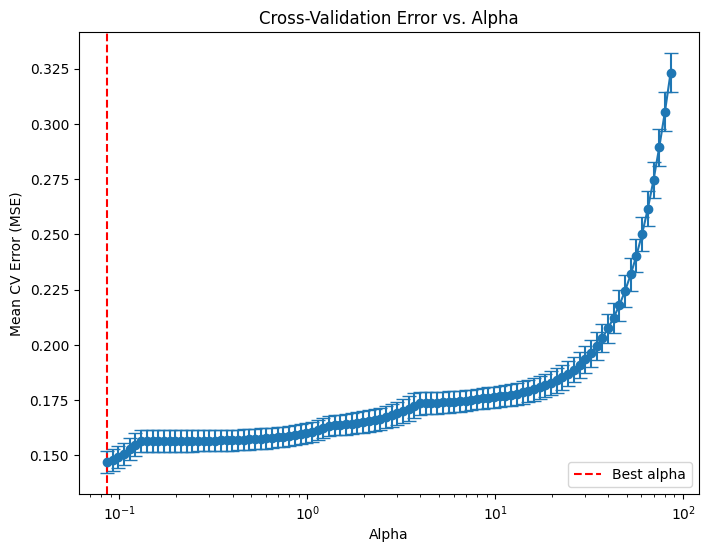

In [ ]:
# Compute the mean and standard deviation of the CV errors for each alpha.
mean_cv_errors = np.mean(lasso_cv.mse_path_, axis=1)
std_cv_errors = np.std(lasso_cv.mse_path_, axis=1)

plt.figure(figsize=(8, 6))
plt.errorbar(lasso_cv.alphas_, mean_cv_errors, yerr=std_cv_errors, marker='o', linestyle='-', capsize=5)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Mean CV Error (MSE)')
plt.title('Cross-Validation Error vs. Alpha')
#plt.gca().invert_xaxis()  # Optionally invert the x-axis so lower alphas (less regularization) appear to the right.
plt.axvline(x=lasso_cv.alpha_, color='red', linestyle='--', label='Best alpha')
plt.legend()
plt.show()

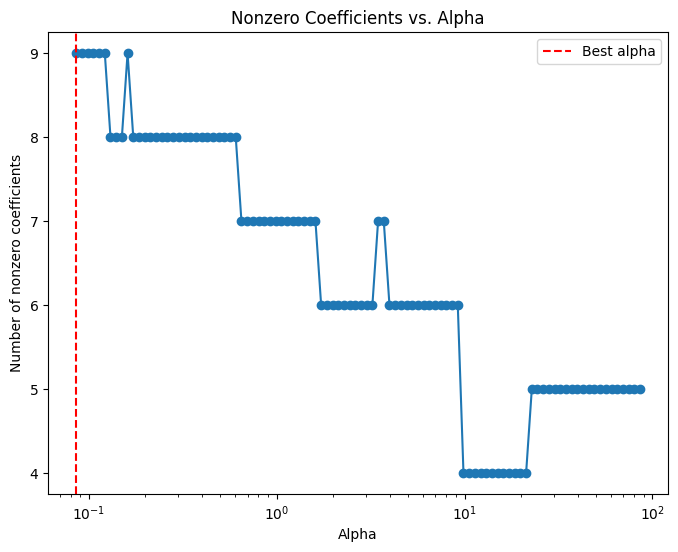

In [ ]:
# Compute the coefficient path over the alpha grid that LassoCV used
alphas, coefs, _ = lasso_path(X_train, y_train,
                              alphas=lasso_cv.alphas_,
                              max_iter=100000)

# Count nonzero coefficients for each alpha (coefs shape: (n_features, n_alphas))
nonzero_counts = np.sum(coefs != 0, axis=0)

# Plot the number of nonzero coefficients versus alpha
plt.figure(figsize=(8,6))
plt.plot(alphas, nonzero_counts, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Number of nonzero coefficients')
plt.title('Nonzero Coefficients vs. Alpha')
#plt.gca().invert_xaxis()  # Lower alphas (less regularization) on the right
plt.axvline(x=lasso_cv.alpha_, color='red', linestyle='--', label='Best alpha')
plt.legend()
plt.show()

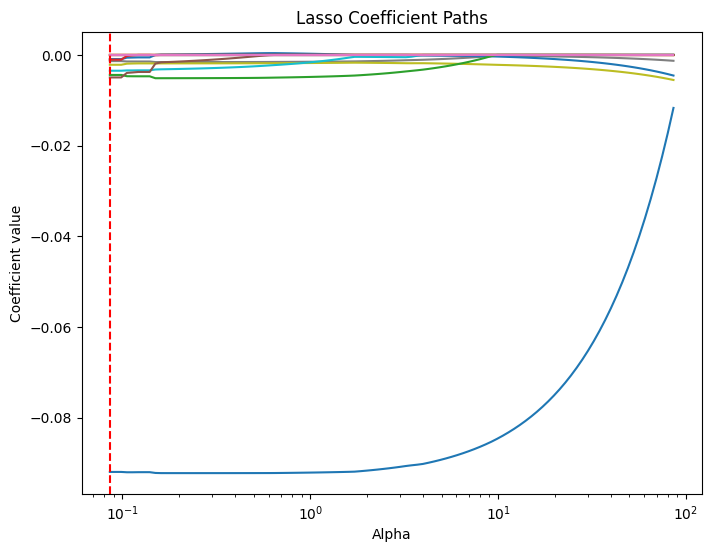

In [ ]:
# Compute the lasso path. Note: we use np.log(y_train) because that's what you used in LassoCV.
alphas, coefs, _ = lasso_path(X_train.values, y_train.values, alphas=lasso_cv.alphas_, max_iter=100000)

plt.figure(figsize=(8, 6))
# Iterate over each predictor and plot its coefficient path.
for i, col in enumerate(X_train.columns):
    plt.plot(alphas, coefs[i, :], label=col)

plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficient value')
plt.title('Lasso Coefficient Paths')
#plt.gca().invert_xaxis()  # Lower alphas (weaker regularization) to the right.
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axvline(x=lasso_cv.alpha_, color='red', linestyle='--', label='Best alpha')
#plt.legend()
plt.show()

In [ ]:
coef_lasso

,predictor,coefficient,exp_coefficient
0,longitude,-0.041993,0.958876
1,latitude,-0.000000,1.000000
2,housingMedianAge,-0.000000,1.000000
3,medianIncome,-0.000000,1.000000
4,AveBedrms,-0.000000,1.000000
5,AveRooms,-0.000000,1.000000
6,AveOccupancy,-0.000000,1.000000
7,housingMedianAge_*_longitude,-0.000979,0.999022
8,medianIncome_*_longitude,-0.001953,0.998049
9,AveBedrms_*_longitude,-0.003542,0.996464


# Q6 - Ridge

In [ ]:
# LassoCV with a range of alpha values
ridge_cv = RidgeCV(alphas=(0.1, 1.0, 100.0),
                   cv = 5)
ridge_cv.fit(X_train.values, y_train.values)

print("LassoCV - Best alpha:", lasso_cv.alpha_)


# Create a DataFrame including the intercept and the coefficients:
coef_ridge = pd.DataFrame({
    'predictor': list(X_train.columns),
    'coefficient':  list(ridge_cv.coef_),
    'exp_coefficient': np.exp(  list(ridge_cv.coef_) )
})


# Evaluate
y_pred_ridge = ridge_cv.predict(X_test.values)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print("LassoCV - MSE:", mse_ridge)


LassoCV - Best alpha: 0.08582268036806916
LassoCV - MSE: 0.12200849787377563


In [ ]:
coef_ridge

,predictor,coefficient,exp_coefficient
0,longitude,-0.151903,0.859072
1,latitude,-0.124598,0.882852
2,housingMedianAge,-0.403642,0.667883
3,medianIncome,0.048240,1.049422
4,AveBedrms,-0.000615,0.999385
5,AveRooms,0.066910,1.069200
6,AveOccupancy,-0.130241,0.877884
7,housingMedianAge_*_longitude,-0.005007,0.995006
8,medianIncome_*_longitude,-0.005414,0.994600
9,AveBedrms_*_longitude,-0.035501,0.965122


# Q7 - Decision Tree for Regression

In [ ]:
dfpd.columns

Index(['longitude', 'latitude', 'housingMedianAge', 'totalRooms',
       'medianIncome', 'medianHouseValue', 'AveBedrms', 'AveRooms',
       'AveOccupancy', 'log_medianHouseValue', 'housingMedianAge_*_longitude',
       'medianIncome_*_longitude', 'AveBedrms_*_longitude',
       'AveRooms_*_longitude', 'AveOccupancy_*_longitude',
       'housingMedianAge_*_latitude', 'medianIncome_*_latitude',
       'AveBedrms_*_latitude', 'AveRooms_*_latitude',
       'AveOccupancy_*_latitude'],
      dtype='object')

In [ ]:
X = dfpd.drop(['log_medianHouseValue', 'totalRooms', 'medianHouseValue', 'housingMedianAge_*_longitude',
       'medianIncome_*_longitude', 'AveBedrms_*_longitude',
       'AveRooms_*_longitude', 'AveOccupancy_*_longitude',
       'housingMedianAge_*_latitude', 'medianIncome_*_latitude',
       'AveBedrms_*_latitude', 'AveRooms_*_latitude',
       'AveOccupancy_*_latitude'], axis = 1)
y = dfpd['log_medianHouseValue']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

Training MSE: 0.156
Test MSE: 0.162


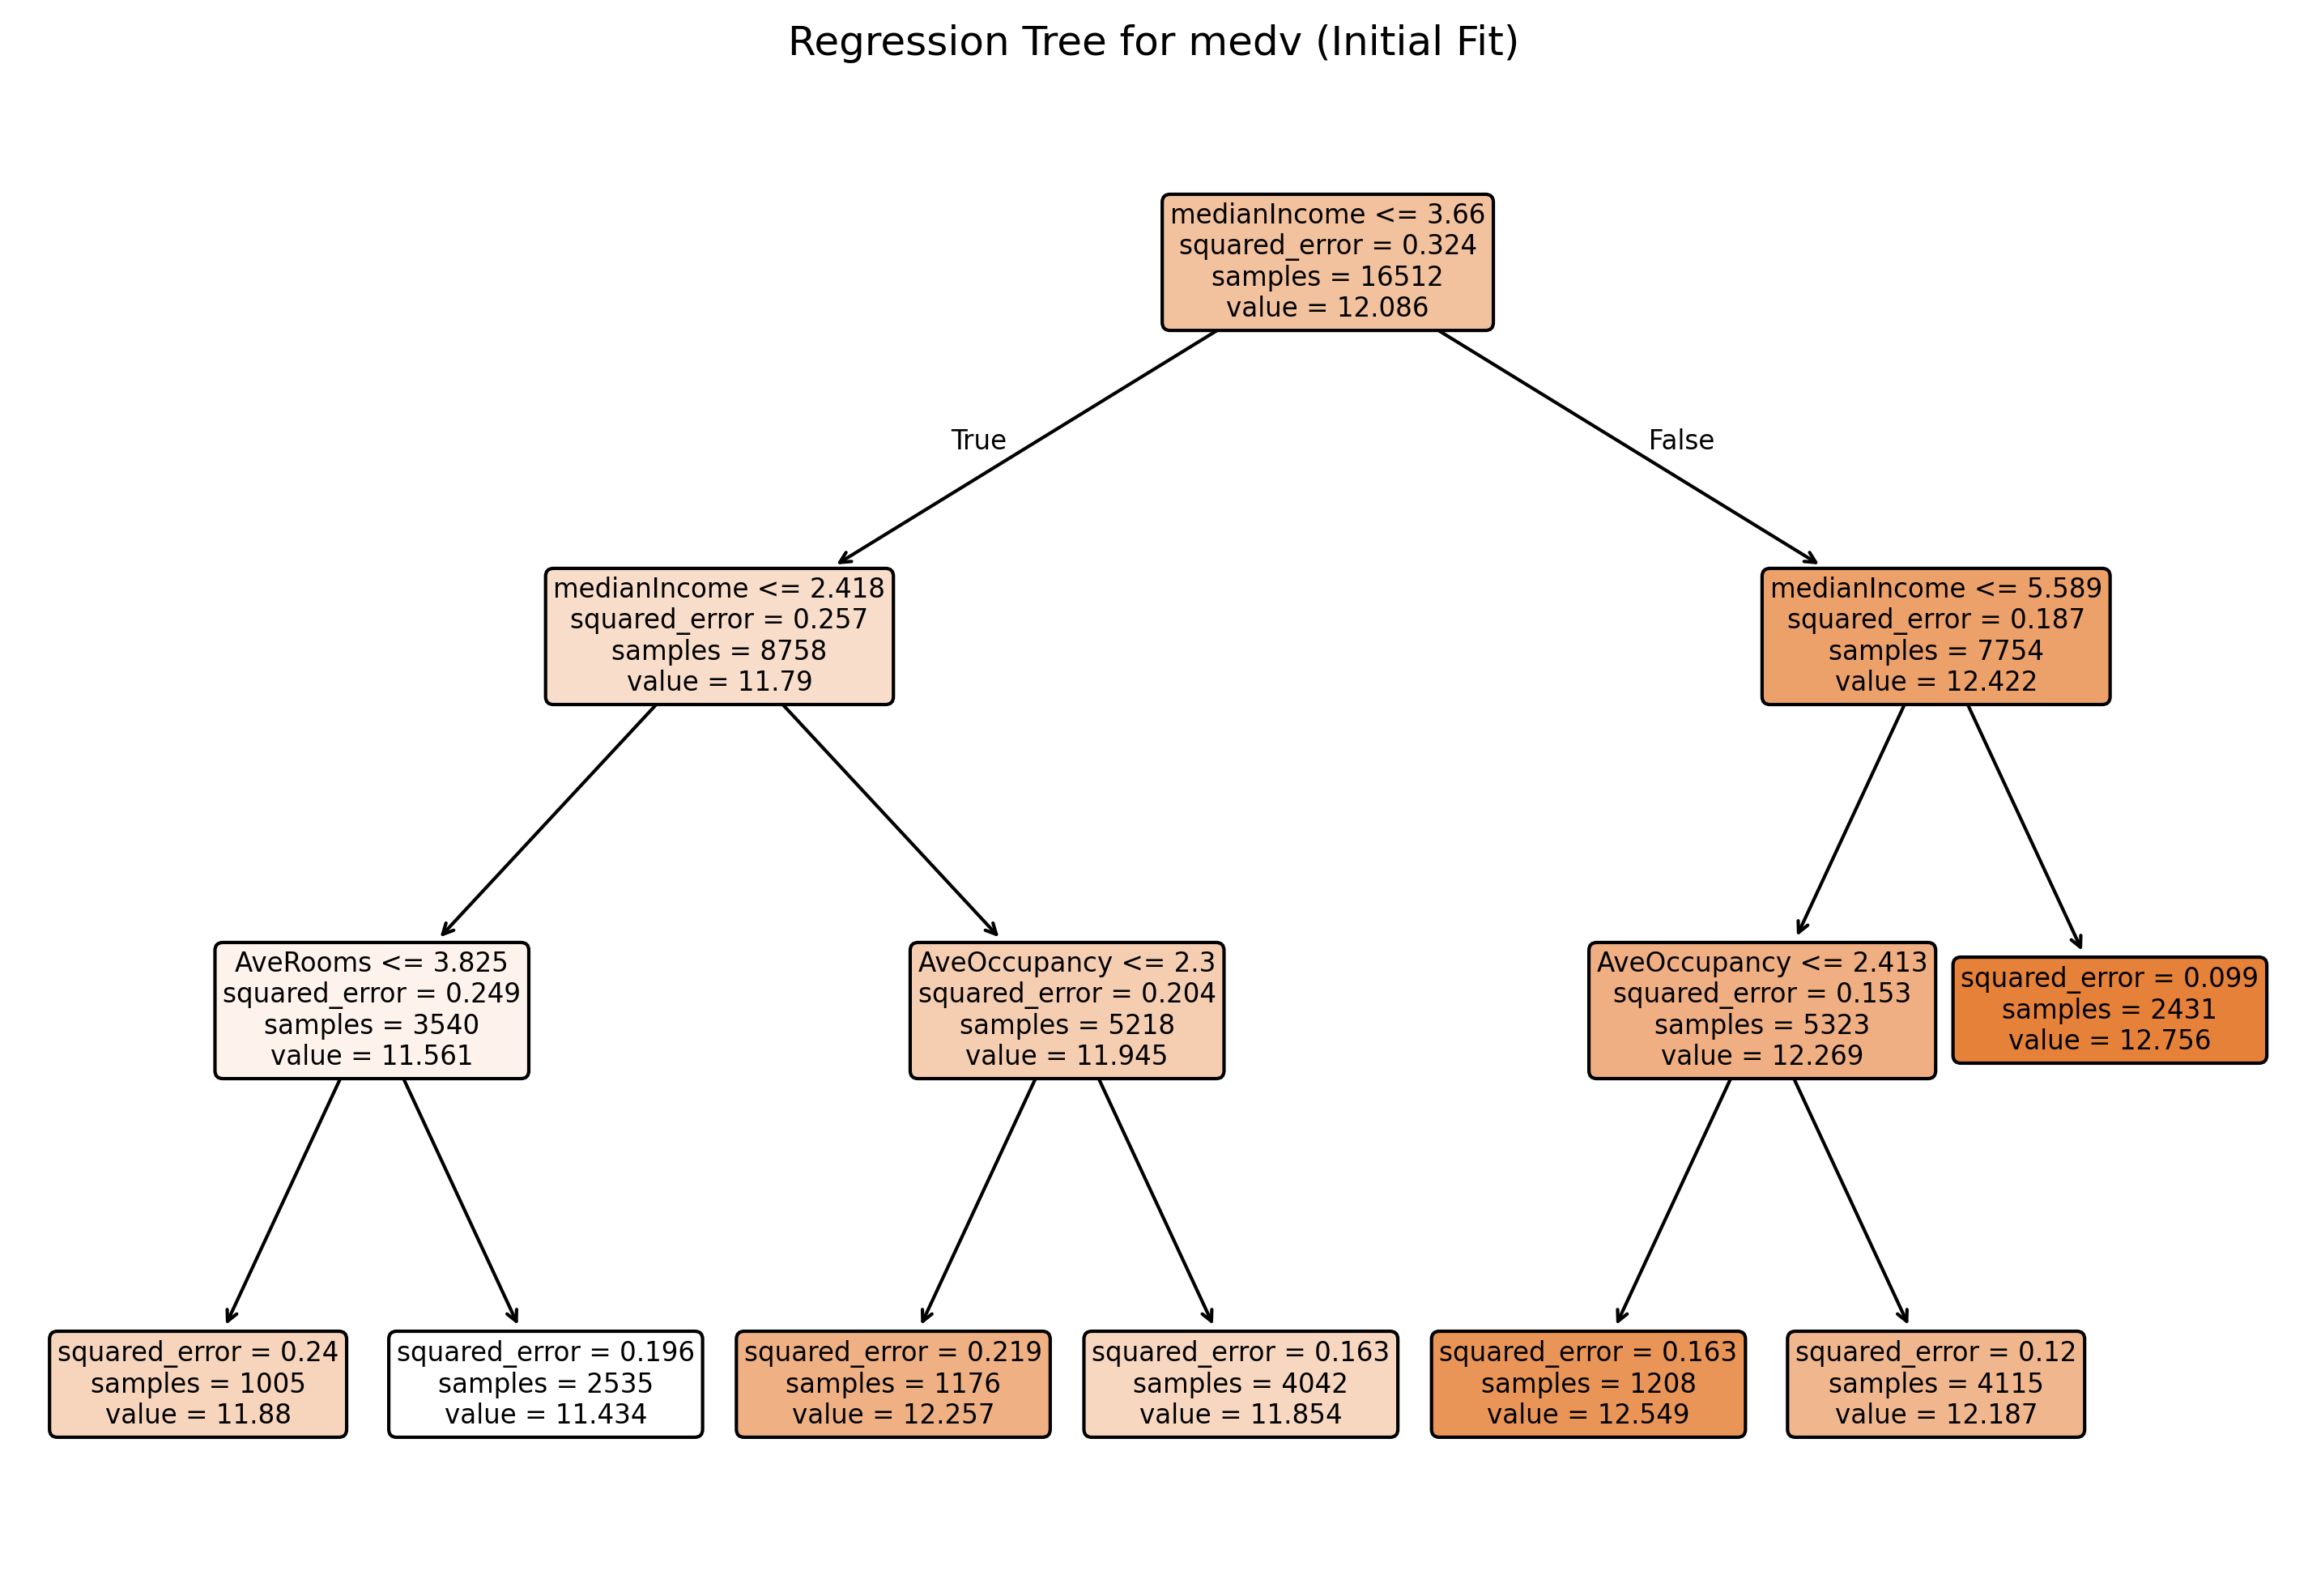

In [ ]:
# In scikit-learn, we can use min_impurity_decrease=0.005 for a similar effect.
tree_model = DecisionTreeRegressor(min_impurity_decrease=0.005, random_state=42)
# Fit the model using all predictors (all columns except 'medv')
tree_model.fit(X_train, y_train)


# Predict on training and test sets
y_train_pred = tree_model.predict(X_train)
y_test_pred = tree_model.predict(X_test)

# Calculate MSE
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Print the results
print(f"Training MSE: {mse_train:.3f}")
print(f"Test MSE: {mse_test:.3f}")

# Plot the initial regression tree
plt.figure(figsize=(12, 8), dpi = 300)
plot_tree(tree_model, feature_names=X_train.columns, filled=True, rounded=True)
plt.title("Regression Tree for medv (Initial Fit)")
plt.show()


# Q8 - Random Forest

In [ ]:
X_train.columns

Index(['longitude', 'latitude', 'housingMedianAge', 'medianIncome',
       'AveBedrms', 'AveRooms', 'AveOccupancy'],
      dtype='object')

In [ ]:

# Build the Random Forest model
# max_features=13 means that at each split the algorithm randomly considers 13 predictors.
rf = RandomForestRegressor(
                          # max_features = 3,
                           n_estimators=500,  # Number of trees in the forest
                           random_state=42,
                           oob_score=True)    # Use out-of-bag samples to estimate error
rf.fit(X_train.values, y_train.values)


# Print the model details
print("Random Forest Model:")
print(rf)

# Output the model details (feature importances, OOB score, etc.)
print("Out-of-bag score:", rf.oob_score_)  # A rough estimate of generalization error


# Generate predictions on training and testing sets
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calculate Mean Squared Errors (MSE) for both sets
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Train MSE:", train_mse)
print("Test MSE:", test_mse)

# Optional: Plot predicted vs. observed values for test data
# plt.figure(figsize=(8,6), dpi=300)
# plt.scatter(y_test, y_test_pred, alpha=0.7)
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
# plt.xlabel("Observed medv")
# plt.ylabel("Predicted medv")
# plt.title("Random Forest: Observed vs. Predicted Values")
# plt.show()

Random Forest Model:
RandomForestRegressor(n_estimators=500, oob_score=True, random_state=42)
Out-of-bag score: 0.8358546364369541
Train MSE: 0.007199716905312015
Test MSE: 0.05565200928824894


Variable Importances:
longitude: 0.1297
latitude: 0.1212
housingMedianAge: 0.0410
medianIncome: 0.4998
AveBedrms: 0.0296
AveRooms: 0.0692
AveOccupancy: 0.1094


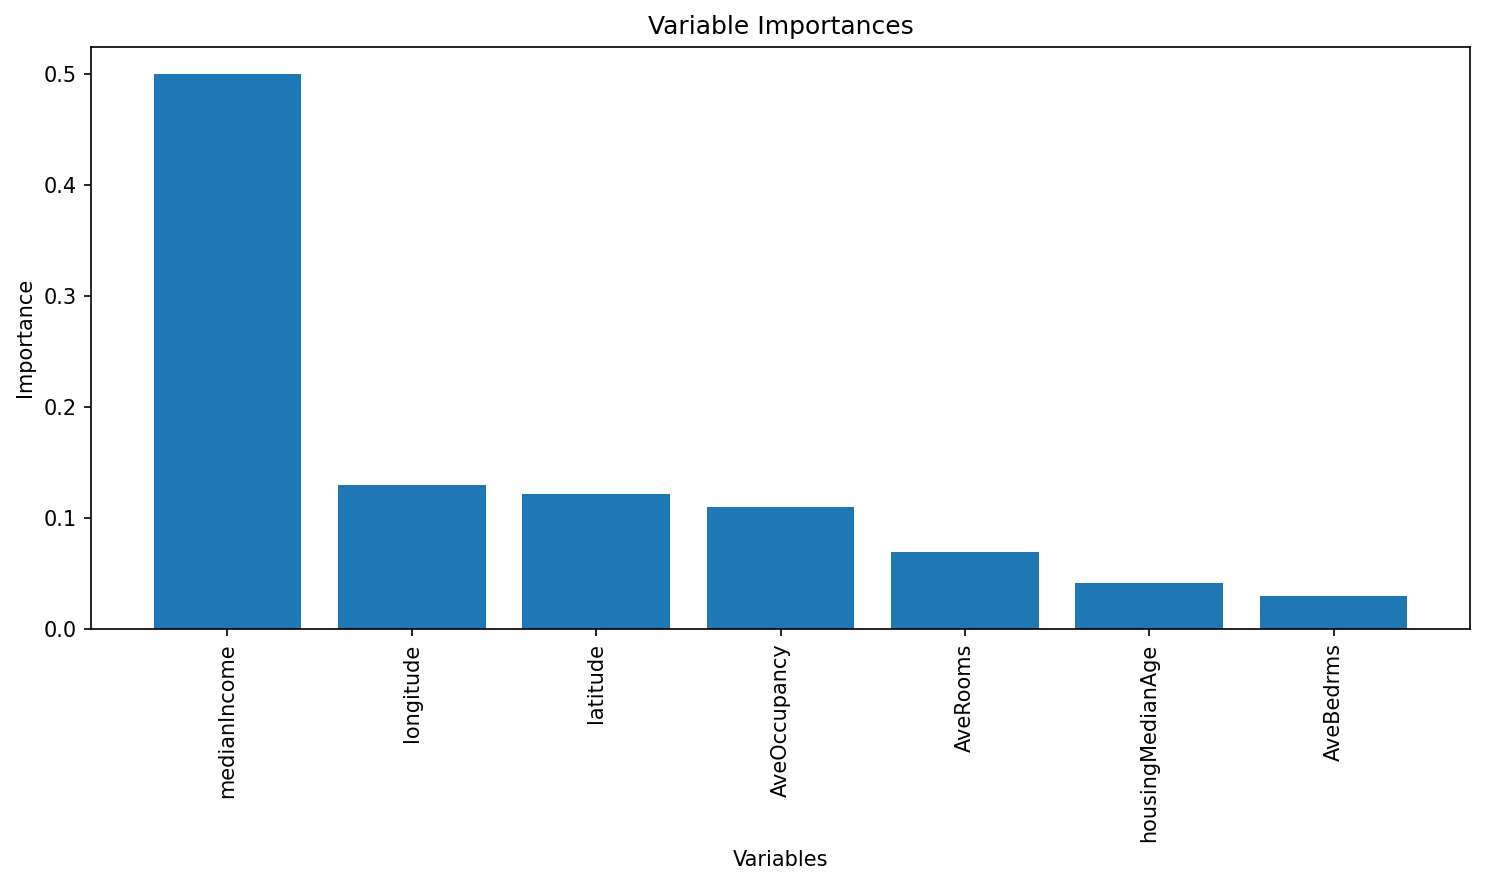

In [ ]:
# Get feature importances from the model (equivalent to importance(bag.boston) in R)
importances = rf.feature_importances_
feature_names = X_train.columns

print("Variable Importances:")
for name, imp in zip(feature_names, importances):
    print(f"{name}: {imp:.4f}")

# Plot the feature importances, similar to varImpPlot(bag.boston) in R
# Sort the features by importance for a nicer plot.
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6), dpi=150)
plt.title("Variable Importances")
plt.bar(range(len(feature_names)), importances[indices], align='center')
plt.xticks(range(len(feature_names)), feature_names[indices], rotation=90)
plt.xlabel("Variables")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# Q9 - Gradient boosting

Fitting 10 folds for each of 80 candidates, totalling 800 fits


<Figure size 1000x800 with 0 Axes>

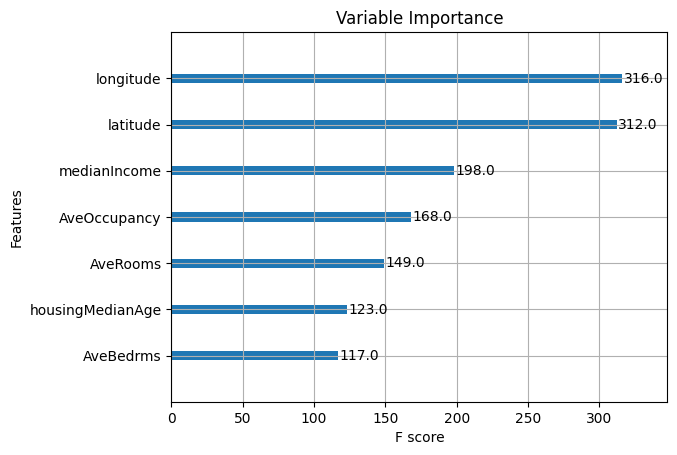

Test MSE: 0.0524737309333073
Best parameters: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1}


In [ ]:
# Define the grid of hyperparameters
param_grid = {
    "n_estimators": list(range(20, 201, 20)),  # nrounds: 20, 40, ..., 200
    "learning_rate": [0.025, 0.05, 0.1, 0.3],  # eta
    "gamma": [0],                              # gamma
    "max_depth": [2, 3],
    "colsample_bytree": [1],
    "min_child_weight": [1],
    "subsample": [1]
}

# Initialize the XGBRegressor with the regression objective and fixed random state for reproducibility
xgb_reg = XGBRegressor(objective="reg:squarederror", random_state=1937, verbosity=1)

# Set up GridSearchCV with 5-fold cross-validation; scoring is negative MSE
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=1  # Adjust verbosity as needed
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Train the final model using the best parameters (grid_search.best_estimator_ is already refit on entire data)
final_model = grid_search.best_estimator_

# Plot variable importance using XGBoost's plot_importance function
plt.figure(figsize=(10, 8))
plot_importance(final_model)
plt.title("Variable Importance")
plt.show()

# Calculate MSE on the test data
y_pred = final_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", test_mse)

# Print the best parameters found by GridSearchCV
best_params = grid_search.best_params_
print("Best parameters:", best_params)

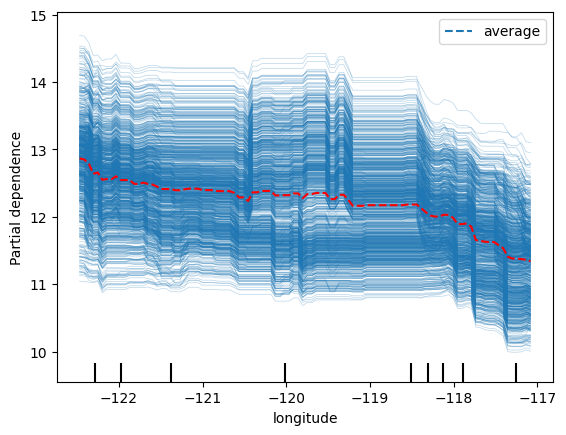

In [ ]:
disp = PartialDependenceDisplay.from_estimator(final_model, X_train, ['longitude'], kind='both')

# Access the line representing the average PDP (it's typically the last Line2D object)
# and change its color manually
for ax in disp.axes_.ravel():
    lines = ax.get_lines()
    if lines:  # In case the axis has line objects
        # The last line is usually the average PDP
        pdp_line = lines[-1]
        pdp_line.set_color("red")  # Change to any color you like

plt.show()

In [ ]:
disp = PartialDependenceDisplay.from_estimator(rf, X_train, ['longitude'], kind='both')

# Access the line representing the average PDP (it's typically the last Line2D object)
# and change its color manually
for ax in disp.axes_.ravel():
    lines = ax.get_lines()
    if lines:  # In case the axis has line objects
        # The last line is usually the average PDP
        pdp_line = lines[-1]
        pdp_line.set_color("red")  # Change to any color you like

plt.show()

KeyboardInterrupt: 

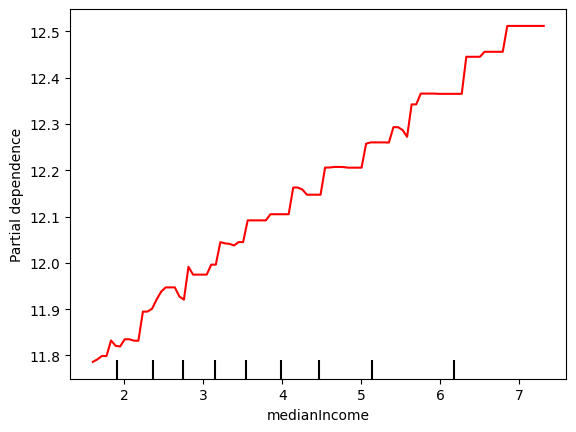

In [ ]:
disp = PartialDependenceDisplay.from_estimator(final_model, X_train, ['medianIncome'], kind='average')

# Access the line representing the average PDP (it's typically the last Line2D object)
# and change its color manually
for ax in disp.axes_.ravel():
    lines = ax.get_lines()
    if lines:  # In case the axis has line objects
        # The last line is usually the average PDP
        pdp_line = lines[-1]
        pdp_line.set_color("red")  # Change to any color you like

plt.show()